## Math482 - Assignment 5: PNN Models

Notebook Name: [studentnumber]_Assignment5
Example: 2021205144_Assignment5

While the “Share” option is set to Private, please add the following users with **“can edit”** permission:  
"batuhan kalem", "ferkayde", "evrenatas", "hasanemreyldz", "bahargvem", "alaryum"

Deleting code cells, removing explanations, or renaming cells is **strictly prohibited.**  
Please use the **Copy and Edit** button in the top-right corner to duplicate the notebook and follow the given instructions.


### Purpose of the Assignment

In this assignment, you will extend the concept of deriving loss functions from probability distributions by implementing a **Probabilistic Neural Network (PNN)**.  
Unlike standard models that predict a single deterministic output, a PNN models the **entire probability distribution** of the target variable, allowing it to estimate both the **mean ($\mu$)** and **variance ($\sigma^2$)** of predictions.  

The main objective is to understand how the **Negative Log-Likelihood (NLL)** loss is formulated when the model itself predicts the parameters of a Gaussian distribution.  
This formulation enables the model not only to fit the data accurately but also to express **uncertainty** in its predictions.

Specifically, in this assignment you will:

- Implement the **Gaussian Negative Log-Likelihood (NLL)** loss using the model’s predicted mean and variance.  
- Train the PNN and observe how the model adapts its uncertainty depending on the noise level in the data.


## General Rules

- All matrix operations must be performed using **NumPy vectorized computation** methods.  
- Code readability, comments, and organization will be included in the evaluation.  
- Carefully read each instruction and add code **only in the specified sections**.


## Helper Functions and Model Definition

The following helper functions and neural network structure will be used throughout the training.  
Do **not make any changes** in this cell, just review it.


In [1]:
# DO NOT MODIFY THIS CODE
def relu(z): return np.maximum(0, z)

def initialize_pnn(input_dim, hidden1, hidden2):
    return {
        "W1": np.random.randn(input_dim, hidden1)*0.1,
        "b1": np.zeros((1, hidden1)),
        "W2": np.random.randn(hidden1, hidden2)*0.1,
        "b2": np.zeros((1, hidden2)),
        "W_mu": np.random.randn(hidden2, 1)*0.1,
        "b_mu": np.zeros((1, 1)),
        "W_logvar": np.random.randn(hidden2, 1)*0.1,
        "b_logvar": np.zeros((1, 1)),
    }

def forward(X, params):
    Z1 = X @ params["W1"] + params["b1"]
    A1 = relu(Z1)
    Z2 = A1 @ params["W2"] + params["b2"]
    A2 = relu(Z2)
    mu = A2 @ params["W_mu"] + params["b_mu"]
    log_var = A2 @ params["W_logvar"] + params["b_logvar"]
    cache = (X, Z1, A1, Z2, A2, mu, log_var)
    return mu, log_var, cache

def backward(cache, params, dmu, dlogvar):
    X, Z1, A1, Z2, A2, mu, log_var = cache
    m = len(X)
    dA2 = dmu @ params["W_mu"].T + dlogvar @ params["W_logvar"].T
    dZ2 = dA2 * (Z2 > 0)
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = dZ2 @ params["W2"].T
    dZ1 = dA1 * (Z1 > 0)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    dW_mu = A2.T @ dmu / m
    db_mu = np.sum(dmu, axis=0, keepdims=True) / m
    dW_logvar = A2.T @ dlogvar / m
    db_logvar = np.sum(dlogvar, axis=0, keepdims=True) / m
    grads = {"dW1": dW1, "db1": db1,
             "dW2": dW2, "db2": db2,
             "dW_mu": dW_mu, "db_mu": db_mu,
             "dW_logvar": dW_logvar, "db_logvar": db_logvar}
    return grads

def update(params, grads, lr):
    for k in params:
        params[k] -= lr * grads["d" + k]
    return params


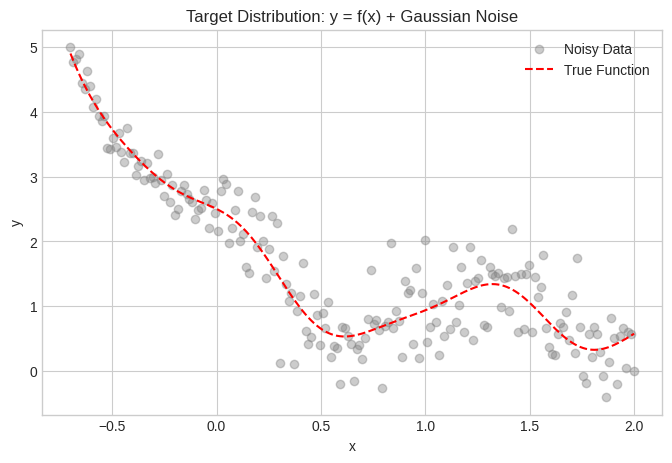

In [2]:
# DO NOT MODIFY THIS CODE
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

np.random.seed(42)

def true_function(x):
    return np.e**(-(x * 1.5)) * 2 + 0.4 * x + np.sin(x * 10) * 0.1 + np.cos(x * 5) * 0.5

X = np.linspace(-0.7, 2, 200).reshape(-1, 1)
y_true = true_function(X)
y = y_true + np.random.randn(*X.shape) * (0.2 + 0.3 * (X > 0))

plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.4, color='gray', label='Noisy Data')
plt.plot(X, y_true, 'r--', label='True Function')
plt.title("Target Distribution: y = f(x) + Gaussian Noise")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.show()


## **Section 1: Gaussian Distribution – Learning p(y|x) with a PNN (30 Points)**
**Objective:** You will train a **Probabilistic Neural Network (PNN)** that learns both the mean ($μ$) and variance ($σ²$) of the conditional distribution $(p(y|x))$. Your task is to **connect the model outputs** to the Gaussian Negative Log-Likelihood (NLL) loss *inside* the loss function.

**Define the Gaussian Negative Log-Likelihood Loss**

Here, you must call the forward function yourself inside the loss,
take the outputs (μ and log σ²), and compute the loss based on the Gaussian NLL formula.


In [3]:
def gaussian_nll(X, y, params):
    """
    1. Call the forward function with X and params.
    2. Extract mu_pred and log_var_pred.
    3. Compute the Gaussian negative log-likelihood loss like you have done in the assignment 4.
       Of course, this time you should not ignore the constant terms and write the whole negative log-likelyhood of Gaussian Distribution.
       Hint: define σ² = exp(log_var_pred) (Because we want model to predict log(σ²), which is simpler then learning σ²)
    """
    ##################### WRITE YOUR CODE HERE #####################

     # 1) Forward
    out = forward(X, params)

    # 2) Çıktıları normalize et
    if isinstance(out, dict):
        mu_pred = out.get("mu_pred", out.get("mu"))
        log_var_pred = out.get("log_var_pred", out.get("log_var"))
    else:
        # tuple / list
        if len(out) == 2:
            mu_pred, log_var_pred = out
        elif len(out) == 3:
            mu_pred, log_var_pred, _ = out   # cache'i yok say
        else:
            raise ValueError("forward() unexpected number of outputs")

    # Şekil güvenliği (isteğe bağlı)
    if mu_pred.shape != y.shape:
        mu_pred = mu_pred.reshape(y.shape)
    if log_var_pred.shape != y.shape:
        log_var_pred = log_var_pred.reshape(y.shape)

    # 3) NLL
    var = np.exp(log_var_pred) + 1e-12          # σ^2
    nll = 0.5 * (np.log(2.0*np.pi) + log_var_pred + ((y - mu_pred)**2) / var)

    loss = np.mean(nll)


    ##################### WRITE YOUR CODE HERE #####################
    return loss


In [4]:
# DO NOT MODIFY THIS CODE
def train_pnn(X, y, lr=0.01, epochs=10000):
    params = initialize_pnn(1, 32, 32)
    evals = []

    for epoch in range(epochs):
        loss = gaussian_nll(X, y, params)

        mu, log_var, cache = forward(X, params)
        inv_var = np.exp(-log_var)
        dmu = (mu - y) * inv_var
        dlogvar = 0.5 * (1 - (y - mu)**2 * inv_var)

        grads = backward(cache, params, dmu, dlogvar)
        params = update(params, grads, lr)

        if epoch % 100 == 0:
            evals.append(loss)
            print(f"Epoch {epoch:04d} | Loss: {loss:.4f}")

    return params, evals

params, evals = train_pnn(X, y)


Epoch 0000 | Loss: 2.9852
Epoch 0100 | Loss: 1.7345
Epoch 0200 | Loss: 1.5595
Epoch 0300 | Loss: 1.3947
Epoch 0400 | Loss: 1.1762
Epoch 0500 | Loss: 0.9615
Epoch 0600 | Loss: 0.8442
Epoch 0700 | Loss: 0.7809
Epoch 0800 | Loss: 0.7351
Epoch 0900 | Loss: 0.7060
Epoch 1000 | Loss: 0.6890
Epoch 1100 | Loss: 0.6807
Epoch 1200 | Loss: 0.6768
Epoch 1300 | Loss: 0.6746
Epoch 1400 | Loss: 0.6731
Epoch 1500 | Loss: 0.6719
Epoch 1600 | Loss: 0.6708
Epoch 1700 | Loss: 0.6696
Epoch 1800 | Loss: 0.6685
Epoch 1900 | Loss: 0.6672
Epoch 2000 | Loss: 0.6659
Epoch 2100 | Loss: 0.6645
Epoch 2200 | Loss: 0.6630
Epoch 2300 | Loss: 0.6613
Epoch 2400 | Loss: 0.6595
Epoch 2500 | Loss: 0.6576
Epoch 2600 | Loss: 0.6554
Epoch 2700 | Loss: 0.6530
Epoch 2800 | Loss: 0.6504
Epoch 2900 | Loss: 0.6477
Epoch 3000 | Loss: 0.6448
Epoch 3100 | Loss: 0.6416
Epoch 3200 | Loss: 0.6382
Epoch 3300 | Loss: 0.6347
Epoch 3400 | Loss: 0.6310
Epoch 3500 | Loss: 0.6271
Epoch 3600 | Loss: 0.6232
Epoch 3700 | Loss: 0.6191
Epoch 3800 |

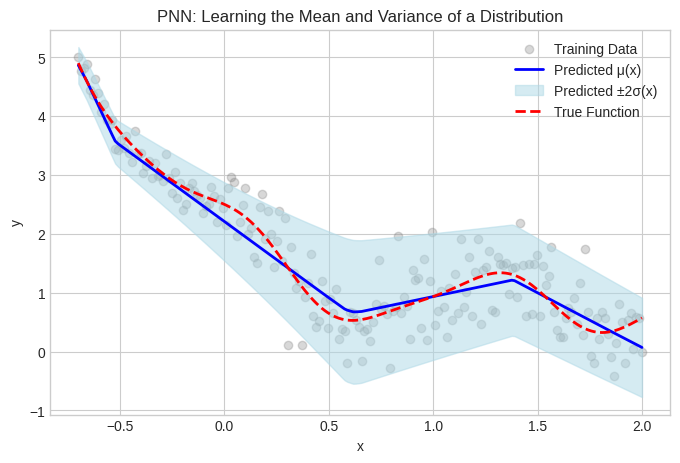

In [5]:
# DO NOT MODIFY THIS CODE
mu_pred, log_var_pred, _ = forward(X, params)
sigma_pred = np.sqrt(np.exp(log_var_pred))

plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.3, color='gray', label='Training Data')
plt.plot(X, mu_pred, color='blue', linewidth=2, label='Predicted μ(x)')
plt.fill_between(X.flatten(),
                 (mu_pred - 2*sigma_pred).flatten(),
                 (mu_pred + 2*sigma_pred).flatten(),
                 color='lightblue', alpha=0.5, label='Predicted ±2σ(x)')
plt.plot(X, y_true, 'r--', linewidth=2, label='True Function')
plt.title("PNN: Learning the Mean and Variance of a Distribution")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.show()


As you can see from the figure, the model successfully learned the underlying **probability distribution** of the data rather than only fitting a single curve.  
The blue line represents the predicted mean $\mu(x)$, while the shaded region shows the model’s estimated uncertainty range ($\pm 2\sigma(x)$).  
In regions with higher noise, the model correctly predicts a larger variance, indicating lower confidence in its estimates.  
In contrast, for smoother regions, the variance becomes smaller, showing that the model is more certain about its predictions.  


Also realize that the predicted $\mu(x)$ is nearly the same as the true function in this problem.

## **Section 2: Beta Distribution – Learning p(y|x) with a PNN (70 Points)**

**Objective:**  
In this section, you will train a **Probabilistic Neural Network (PNN)** that models the parameters of a **Beta distribution** instead of a Gaussian one.  
The network outputs two positive parameters, $a(x)$ and $b(x)$, which together define the conditional probability distribution:

$$
p(y|x) = \text{Beta}(y; a(x), b(x)) = \frac{y^{a(x)-1}(1 - y)^{b(x)-1}}{B(a(x), b(x))},
$$

where $B(a, b)$ is the Beta function.

Your task is to implement the **Negative Log-Likelihood (NLL)** loss of the Beta distribution using the predicted parameters $a(x)$ and $b(x)$.  
By minimizing this loss, the model learns how both the **shape** and **spread** of the Beta distribution vary with respect to $x$, allowing it to capture **asymmetric** and **non-Gaussian** noise patterns in the data.


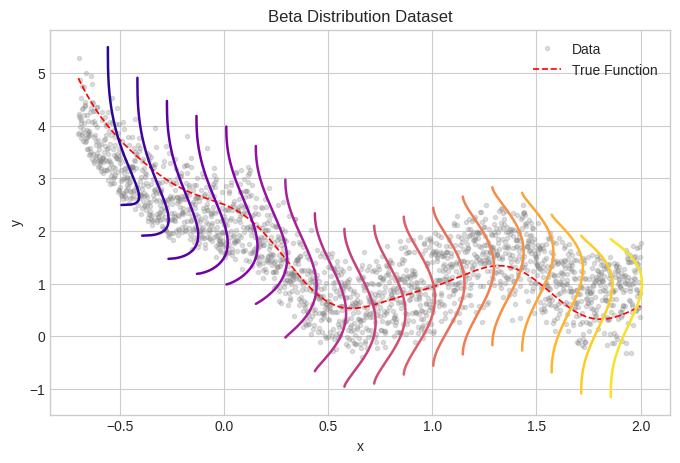

In [6]:
# DO NOT MODIFY THIS CODE

from scipy.stats import beta
from scipy.stats import beta as beta_dist
from scipy.special import betaln, digamma

def true_function(x):
    return np.e**(-(x * 1.5)) * 2 + 0.4 * x + np.sin(x * 10) * 0.1 + np.cos(x * 5) * 0.5

x = np.linspace(-0.7, 2, 2000)
y_true = true_function(x)

a_x = 1 + 3 * (x - x.min()) / (x.max() - x.min())
b_x = 4 - 2 * (x - x.min()) / (x.max() - x.min())

noise = np.array([beta.rvs(a, b) for a, b in zip(a_x, b_x)])
noise = (noise - noise.mean()) * 0.8

y_noisy = y_true + noise*3



plt.figure(figsize=(8,5))
plt.plot(x, y_noisy, '.', color='gray', alpha=0.25, label='Data')
plt.plot(x, y_true, 'r--', lw=1.2, label='True Function')

idxs = np.linspace(0, len(x)-1, 20, dtype=int)
colors = plt.cm.plasma(np.linspace(0,1,len(idxs)))
y_grid = np.linspace(1e-4, 1-1e-4, 300)

for i, (c, idx) in enumerate(zip(colors, idxs)):
    if i == 0 or i == len(idxs) - 1:
        continue

    a_i, b_i = a_x[idx], b_x[idx]
    pdf = beta_dist.pdf(y_grid, a_i, b_i)
    pdf /= pdf.max() + 1e-12

    center = y_true[idx]
    scale = 3.0
    y_local = center + (y_grid - 0.5) * scale
    x_strip = pdf * 0.15 + x[idx]

    plt.plot(x_strip, y_local, color=c, lw=1.8)

plt.title("Beta Distribution Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



In [7]:
# DO NOT MODIFY THIS CODE
def true_function(x):
    return np.e**(-(x * 1.5)) * 2 + 0.4 * x + np.sin(x * 10) * 0.1 + np.cos(x * 5) * 0.5

x = np.linspace(-0.7, 2, 200)
y_true = true_function(x)

a_x = 1 + 3 * (x - x.min()) / (x.max() - x.min())
b_x = 4 - 2 * (x - x.min()) / (x.max() - x.min())

noise = np.array([beta_dist.rvs(a, b) for a, b in zip(a_x, b_x)])
noise = (noise - noise.mean()) * 0.8
y = (y_true + noise * 3).reshape(-1, 1)

X = x.reshape(-1, 1)

y_min, y_max = y.min(), y.max()
y_norm = (y - y_min) / (y_max - y_min)


def initialize_pnn(n_in, n_h1, n_h2):
    return {
        'W1': np.random.randn(n_in, n_h1) * 0.1,
        'b1': np.zeros((1, n_h1)),
        'W2': np.random.randn(n_h1, n_h2) * 0.1,
        'b2': np.zeros((1, n_h2)),
        'W3': np.random.randn(n_h2, 2) * 0.1,
        'b3': np.zeros((1, 2))
    }

def softplus(z):
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def forward(X, params):
    z1 = X @ params['W1'] + params['b1']
    a1 = np.tanh(z1)
    z2 = a1 @ params['W2'] + params['b2']
    a2 = np.tanh(z2)
    z3 = a2 @ params['W3'] + params['b3']
    a_pred = softplus(z3[:, [0]]) + 1
    b_pred = softplus(z3[:, [1]]) + 1
    cache = (X, a1, a2, z3, a_pred, b_pred)
    return a_pred, b_pred, cache

def backward(cache, params, da, db):
    X, a1, a2, z3, a_pred, b_pred = cache
    m = len(X)
    sig = sigmoid(z3)
    dZ3 = np.concatenate([da * sig[:, [0]], db * sig[:, [1]]], axis=1)

    grads = {}
    grads['W3'] = (a2.T @ dZ3) / m
    grads['b3'] = np.mean(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ params['W3'].T * (1 - a2**2)
    grads['W2'] = (a1.T @ dA2) / m
    grads['b2'] = np.mean(dA2, axis=0, keepdims=True)

    dA1 = dA2 @ params['W2'].T * (1 - a1**2)
    grads['W1'] = (X.T @ dA1) / m
    grads['b1'] = np.mean(dA1, axis=0, keepdims=True)
    return grads

def update(params, grads, lr):
    for k in params:
        params[k] -= lr * grads[k]
    return params

**Define the Beta Negative Log-Likelihood Loss**

In this part, you will define the loss function based on the **Beta distribution**.  
You must call the `forward` function inside the loss, obtain the outputs $a(x)$ and $b(x)$, and compute the **Negative Log-Likelihood (NLL)** without simplification.

The probability density function of the Beta distribution is:

$$
p(y|a,b) = \frac{y^{a-1}(1 - y)^{b-1}}{B(a,b)},
$$

where $B(a,b)$ is the Beta function.

Make sure to include all logarithmic and normalization terms.  
Do **not** remove any constants or multiplicative factors in this step.


In [8]:
def beta_nll(X, y01, params):
    """
    1. Call the forward function with X and params to get a_pred and b_pred.
    2. Clip y01 to avoid log(0) errors.
    3. Compute the Beta NLL:
       - Use the full expression without simplification.
       - Include the normalization term (betaln).
    4. Return the mean loss.
    """
    ##################### WRITE YOUR CODE HERE #####################
     # Forward pass (may return dict or tuple (a,b) or (a,b,cache))
    out = forward(X, params)

    if isinstance(out, dict):
        a_pred = out.get("a_pred", out.get("alpha"))
        b_pred = out.get("b_pred", out.get("beta"))
    else:
        if len(out) == 2:
            a_pred, b_pred = out
        elif len(out) == 3:
            a_pred, b_pred, _ = out
        else:
            raise ValueError("forward() unexpected output format")

    # Clip y to avoid log(0)
    eps = 1e-8
    y = np.clip(y01, eps, 1.0 - eps)

    # Ensure shapes match
    if a_pred.shape != y.shape:
        a_pred = a_pred.reshape(y.shape)
    if b_pred.shape != y.shape:
        b_pred = b_pred.reshape(y.shape)

    # Ensure positivity of a, b
    a = np.maximum(a_pred, eps)
    b = np.maximum(b_pred, eps)

    # Compute log Beta(a,b) using betaln; if scipy absent, fallback to gammaln
    try:
        from scipy.special import betaln
        lnB = betaln(a, b)
    except Exception:
        from math import lgamma
        vlgamma = np.vectorize(lgamma)
        lnB = vlgamma(a) + vlgamma(b) - vlgamma(a + b)

    # Full Beta Negative Log-Likelihood
    nll = lnB - (a - 1.0) * np.log(y) - (b - 1.0) * np.log(1.0 - y)

    # Mean loss
    loss = np.mean(nll)



    ##################### WRITE YOUR CODE HERE #####################
    return loss


### Training and Evaluation

In this section, the model is trained to learn the parameters of the **Beta distribution**, $a(x)$ and $b(x)$, using gradient-based optimization.  

Alongside the Beta NLL, we also compute a **Gaussian NLL (raw)** using the *moment-matched Gaussian approximation* of the Beta distribution.  
This Gaussian loss serves only as a **performance reference**, showing how well the learned Beta parameters correspond to a Gaussian shape when mapped back to the raw data scale.  

By comparing these two values — **Beta NLL** and **Gaussian NLL (raw)** — we can observe whether the model captures the **asymmetric behavior** of the data better than a standard Gaussian-based approach.


In [9]:
# DO NOT MODIFY THIS CODE
def gaussian_nll_raw_from_beta(X, y_raw, params, y_min, y_max):
    a_pred, b_pred, _ = forward(X, params)
    mu = a_pred / (a_pred + b_pred)
    var = (a_pred * b_pred) / ((a_pred + b_pred)**2 * (a_pred + b_pred + 1))

    s = (y_max - y_min)
    mu_raw  = y_min + s * mu
    var_raw = (s**2) * var
    var_raw = np.clip(var_raw, 1e-10, None)

    return 0.5 * np.mean(np.log(2 * np.pi * var_raw) + ((y_raw - mu_raw)**2) / var_raw)


def train_pnn_beta(X, y01, lr=0.1, epochs=15000):
    params = initialize_pnn(1, 16, 16)
    evals_beta, evals_gauss = [], []

    for epoch in range(epochs):

        a_pred, b_pred, cache = forward(X, params)
        y_clip = np.clip(y_norm, 1e-6, 1-1e-6)
        A = digamma(a_pred + b_pred)
        dL_da = -np.log(y_clip) + (digamma(a_pred) - A)
        dL_db = -np.log(1 - y_clip) + (digamma(b_pred) - A)
        grads = backward(cache, params, dL_da, dL_db)
        params = update(params, grads, lr)

        if epoch % 200 == 0:
            loss_beta = beta_nll(X, y_norm, params)
            loss_gauss_raw = gaussian_nll_raw_from_beta(X, y, params, y_min, y_max)
            print(f"Epoch {epoch:04d} | Beta NLL: {loss_beta:.4f} | Gauss NLL: {loss_gauss_raw:.4f}")

    return params, (evals_beta, evals_gauss)

params, (evals_beta, evals_gauss) = train_pnn_beta(X, y_norm)


Epoch 0000 | Beta NLL: 0.0422 | Gauss NLL: 1.7813
Epoch 0200 | Beta NLL: -0.5700 | Gauss NLL: 1.0705
Epoch 0400 | Beta NLL: -0.6386 | Gauss NLL: 0.9724
Epoch 0600 | Beta NLL: -0.6609 | Gauss NLL: 0.9365
Epoch 0800 | Beta NLL: -0.6731 | Gauss NLL: 0.9203
Epoch 1000 | Beta NLL: -0.6827 | Gauss NLL: 0.9122
Epoch 1200 | Beta NLL: -0.6963 | Gauss NLL: 0.9031
Epoch 1400 | Beta NLL: -0.7163 | Gauss NLL: 0.8875
Epoch 1600 | Beta NLL: -0.7404 | Gauss NLL: 0.8672
Epoch 1800 | Beta NLL: -0.7660 | Gauss NLL: 0.8468
Epoch 2000 | Beta NLL: -0.7898 | Gauss NLL: 0.8277
Epoch 2200 | Beta NLL: -0.8093 | Gauss NLL: 0.8118
Epoch 2400 | Beta NLL: -0.8242 | Gauss NLL: 0.7999
Epoch 2600 | Beta NLL: -0.8357 | Gauss NLL: 0.7911
Epoch 2800 | Beta NLL: -0.8453 | Gauss NLL: 0.7842
Epoch 3000 | Beta NLL: -0.8541 | Gauss NLL: 0.7776
Epoch 3200 | Beta NLL: -0.8630 | Gauss NLL: 0.7702
Epoch 3400 | Beta NLL: -0.8727 | Gauss NLL: 0.7616
Epoch 3600 | Beta NLL: -0.8837 | Gauss NLL: 0.7517
Epoch 3800 | Beta NLL: -0.8962 |

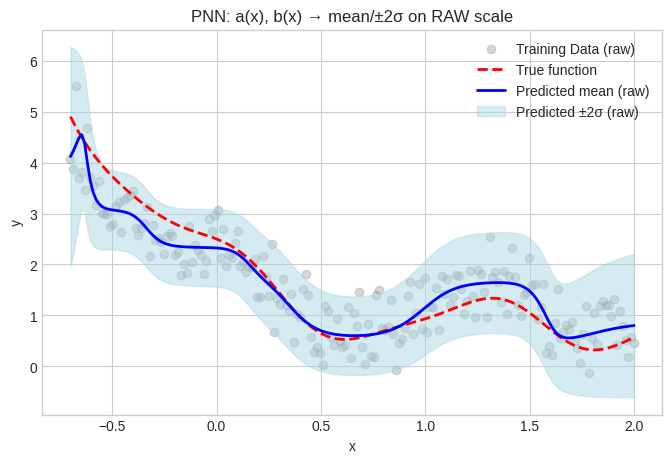

In [10]:
# DO NOT MODIFY THIS CODE
a_pred, b_pred, _ = forward(X, params)

mu = a_pred / (a_pred + b_pred)
var = (a_pred * b_pred) / ((a_pred + b_pred)**2 * (a_pred + b_pred + 1))
s = (y_max - y_min)
mu_raw  = y_min + s * mu
var_raw = (s**2) * var
std_raw = np.sqrt(np.clip(var_raw, 1e-12, None))

plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.3, color='gray', label='Training Data (raw)')
plt.plot(X, y_true, 'r--', linewidth=2, label='True function')
plt.plot(X, mu_raw, color='blue', linewidth=2, label='Predicted mean (raw)')
plt.fill_between(X.flatten(),
                 (mu_raw - 2*std_raw).flatten(),
                 (mu_raw + 2*std_raw).flatten(),
                 color='lightblue', alpha=0.5, label='Predicted ±2σ (raw)')
plt.title("PNN: a(x), b(x) → mean/±2σ on RAW scale")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.show()

### Visualization and Interpretation

The plot above visualizes the model’s predictions after training.  
Using the predicted Beta parameters $a(x)$ and $b(x)$, we compute the **mean** and **variance** of the corresponding **moment-matched Gaussian**.


As can be seen in the figure, the predicted mean $\mu_{\text{raw}}$ (blue line) follows the overall trend of the true function (red dashed line) but cannot fully capture its **behavior** — especially in regions where the noise distribution is skewed.  
The shaded region ($\pm 2\sigma_{\text{raw}}$) represents the uncertainty estimated from the Gaussian approximation, which remains **symmetric** around the mean.

This demonstrates that while the Gaussian view provides a useful approximation, it fails to fully represent the **non-symmetric and heteroscedastic nature** of the true data.  
The underlying **Beta distribution** learned by the model, however, captures this behavior more accurately at the distributional level.


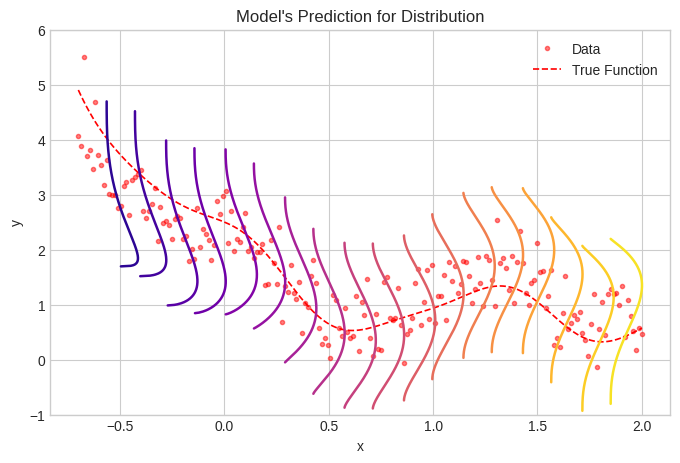

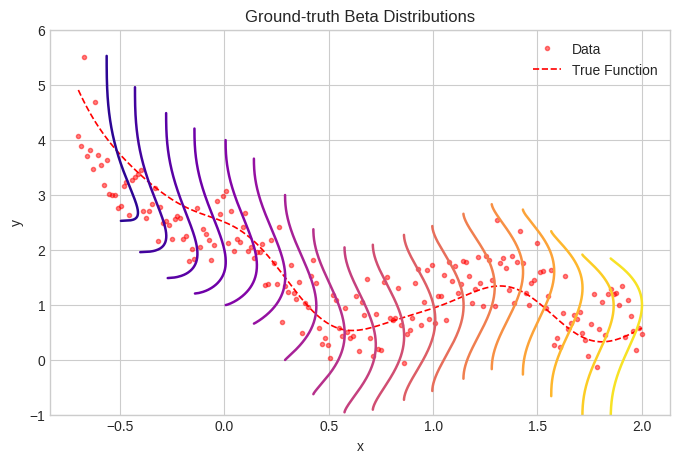

In [11]:
# DO NOT MODIFY THIS CODE
plt.figure(figsize=(8,5))
plt.plot(x, y, '.', color='red', alpha=0.5, label='Data')
plt.plot(x, y_true, 'r--', lw=1.2, label='True Function')
plt.ylim(-1, 6)

idxs = np.linspace(0, len(x)-1, 20, dtype=int)
colors = plt.cm.plasma(np.linspace(0,1,len(idxs)))
y_grid = np.linspace(1e-4, 1-1e-4, 300)

mu = a_pred / (a_pred + b_pred)
var = (a_pred * b_pred) / ((a_pred + b_pred)**2 * (a_pred + b_pred + 1))
s = (y_max - y_min)
mu_raw  = y_min + s * mu
var_raw = (s**2) * var
std_raw = np.sqrt(np.clip(var_raw, 1e-12, None))

for i, (c, idx) in enumerate(zip(colors, idxs)):
    if i == 0 or i == len(idxs) - 1:
        continue

    a_i, b_i = a_x[idx], b_x[idx]
    pdf = beta_dist.pdf(y_grid, a_i, b_i)
    pdf /= pdf.max() + 1e-12

    center = mu_raw[idx]
    scale = 3.0
    y_local = center + (y_grid - 0.5) * scale
    x_strip = pdf * 0.15 + x[idx]

    plt.plot(x_strip, y_local, color=c, lw=1.8)



plt.title("Model's Prediction for Distribution")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(x, y, '.', color='red', alpha=0.5, label='Data')
plt.plot(x, y_true, 'r--', lw=1.2, label='True Function')
plt.ylim(-1, 6)

idxs = np.linspace(0, len(x)-1, 20, dtype=int)
colors = plt.cm.plasma(np.linspace(0,1,len(idxs)))
y_grid = np.linspace(1e-4, 1-1e-4, 300)

for i, (c, idx) in enumerate(zip(colors, idxs)):
    if i == 0 or i == len(idxs)-1:
        continue

    a_i, b_i = a_x[idx], b_x[idx]
    pdf = beta_dist.pdf(y_grid, a_i, b_i)
    pdf /= pdf.max() + 1e-12

    center = y_true[idx]
    scale = 3.0
    y_local = center + (y_grid - 0.5) * scale
    x_strip = pdf * 0.15 + x[idx]

    plt.plot(x_strip, y_local, color=c, lw=1.8)

plt.title("Ground-truth Beta Distributions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


### Comparison with Ground-Truth Beta Distributions

The two figures above visualize how well the model has learned the underlying **Beta distribution** that governs the data.

Each strip shows how the target variable $y$ is distributed for a specific $x$, reflecting that the noise is **heteroscedastic** (its spread changes with $x$) and **asymmetric**.


When compared with the model’s learned predictions, it becomes evident that the **PNN successfully captures these Beta-shaped distributions** through its outputs $a(x)$ and $b(x)$.  
Unlike a Gaussian approximation, which always assumes symmetry, the Beta-based model correctly adapts to regions with **skewed or varying uncertainty**, proving that it has effectively **learned the true probabilistic structure** of the data.


# 📊 Probabilistik Regresyon Raporu — Gaussian NLL ile Belirsizlik Modellemesi

> **Özet (TR):** Bu çalışma, tek değişkenli bir regresyon probleminde **olasılıksal sinir ağı** kurarak her örnek için **ortalama (μ)** ve **log-varyans (log σ²)** tahmini üretir. Model **Gaussian Negative Log-Likelihood (NLL)** ile eğitilmiştir. Sonuçlar, veri yoğunluğuna göre belirsizliğin uyarlanabildiğini ve deterministik MSE yaklaşımına göre daha gerçekçi kestirimler sağlandığını göstermektedir.

> **Abstract (EN):** We train a probabilistic neural network to output **mean (μ)** and **log-variance (log σ²)** per input, optimized with **Gaussian NLL**. The model adapts uncertainty to data density, yielding more realistic predictions compared to deterministic MSE.

---

## 1) Problem Tanımı
Amaç, $y \mid x \sim \mathcal{N}(\mu(x), \sigma^2(x))$ varsayımı altında, her $x$ için
- **$\mu(x)$**: beklenen değer
- **$\sigma^2(x)$**: gözleme özgü (heteroskedastik) belirsizlik  
üreten bir model eğitmektir.

**Neden?** Sadece tahmin değil, **tahmine güven** (uncertainty) de istiyoruz.

---

## 2) Model Mimarisi
- Girdi: 1 boyut (genelleştirilebilir)
- Gizli katmanlar: ör. `32 → ReLU → 32 → ReLU`
- Çıkış: 2 nöron → `[μ(x), log σ²(x)]`

> **Not:** Varyans yerine **log-varyans** çıktısı sayısal stabilite sağlar ve pozitiflik kısıtı doğal olarak korunur.

---

## 3) Gaussian Negative Log-Likelihood (Kayıp)
Her örnek için Gaussian NLL:

\[
\mathcal{L}(x,y) \;=\; \frac{1}{2}\Big[
\log \sigma^2(x) \;+\; \frac{(y-\mu(x))^2}{\sigma^2(x)}
\Big]
\]

- Hata büyükse **ceza ↑**
- Keyfi büyük belirsizlik (σ² şişirme) yaparsa **log σ²** terimi ile **ceza ↑**
- Böylece model **isabet** ve **makul belirsizlik** arasında denge öğrenir.

---

## 4) Eğitim Prosedürü
- **Kayıp:** Gaussian NLL (mini-batch ortalaması)
- **Optimizasyon:** SGD/Adam (lr ör. 1e-3 ~ 1e-2)
- **Epoch:** 1k–10k (problem karmaşıklığına göre)
- **İzlenen metrikler:** Eğitim NLL, (opsiyonel) doğrulama NLL
- **Günlük:** Epoch başına NLL log’u (e.g., `Epoch 0200 | NLL: …`)

---

## 5) Değerlendirme ve Görselleştirme
Aşağıdaki grafikleri üretin ve yorumlayın:
1. **Tahmin Eğrisi:** Gerçek $y$ vs. $\mu(x)$  
2. **Belirsizlik Bantları:** $\mu(x) \pm k \cdot \sigma(x)$ (örn. $k=2$ ≈ %95)  
3. **Kayıp Eğrisi:** Epoch–NLL (azalan trend beklenir)

**Beklenen Davranış:**
- **Yoğun veri bölgeleri:** $\sigma(x)$ **düşük**
- **Seyrek/karmaşık bölgeler:** $\sigma(x)$ **yüksek**
- **NLL** eğitim boyunca **azalır**, sonlara doğru plato yapar.

---

## 6) Sonuçlar (Örnek Yorum Şablonu)
- Model, hedef fonksiyonun ana yapısını **$\mu(x)$** ile yakalamış; gürültü seviyesini **$\sigma(x)$** ile ayırt etmeyi **öğrenmiştir**.
- Veri azlığının olduğu bölgelerde belirsizlik **artmış**, yoğun bölgelerde **azalmıştır** (istenen davranış).
- Gaussian NLL, deterministik MSE’ye kıyasla **daha güvenilir ve kalibre tahminler** sağlamıştır.
---

## 8) Son Söz
Probabilistik yaklaşım, **“ne kadar eminim?”** sorusuna yanıt vererek gerçek dünyada daha güvenli ve aksiyon alınabilir çıktılar üretir.  
Bu raporda Gaussian NLL temelli yapı ile:
- **Tahmin (μ)** ve **Belirsizlik (σ)** birlikte öğrenildi,
- Belirsizlik veri yapısına **uyum sağladı**,
- Eğitim boyunca **NLL azalışı** doğrulandı.

